In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/teo/userdata/SejongMusic


In [21]:
from sejong_music.yeominrak_processing import ShiftedAlignedScore, OrchestraScore
from sejong_music.model_zoo import QkvAttnSeq2seqOrch, get_emb_total_size
from sejong_music.decode import MidiDecoder, OrchestraDecoder
from omegaconf import OmegaConf

In [18]:
config = OmegaConf.load('yamls/orchestration.yaml')
config = get_emb_total_size(config)


In [35]:
train_dataset = OrchestraScore(is_valid= False, 
                              xml_path='music_score/FullScore_edit3.musicxml',
                              use_pitch_modification = config.data.use_pitch_modification, 
                              pitch_modification_ratio=config.data.modification_ratio,
                              min_meas=config.data.min_meas, 
                              max_meas=config.data.max_meas,
                              feature_types=config.model.features,
                              sampling_rate=config.data.sampling_rate
                              )

In [62]:
train_dataset.slice_info[90]

[104, 105, 106, 107]

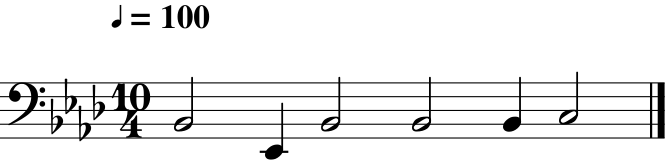

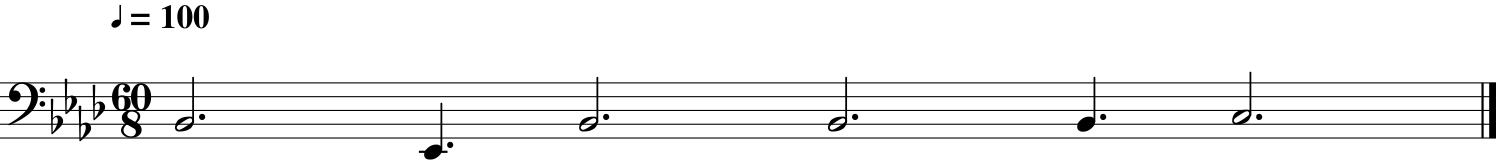

In [63]:
idx = 104
source_decoder(train_dataset.era_dataset.measure_features[-1][idx]).show()
decoder(train_dataset.measure_features[-1][idx]).show()

In [19]:
model = QkvAttnSeq2seqOrch(train_dataset.era_dataset.tokenizer, train_dataset.tokenizer, config.model)

In [23]:
decoder = OrchestraDecoder(train_dataset.tokenizer)
source_decoder = MidiDecoder(train_dataset.era_dataset.tokenizer)


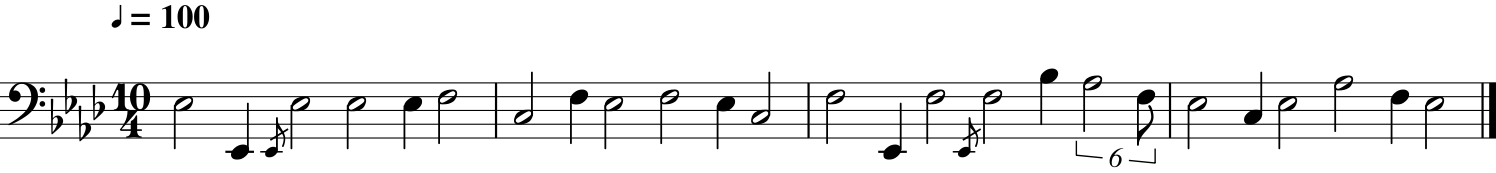

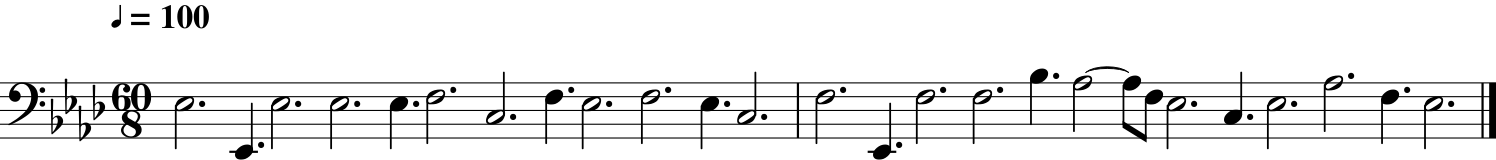

In [79]:
# src, shifted_tgt, tgt = train_dataset[80]
idx = 130
src, shifted_tgt, tgt = train_dataset.get_processed_feature(7, 4, idx)
source_decoder(model.enc_converter(src[1:-1])).show()
decoder(model.converter(tgt[:-1])).show()

In [80]:
tgt

tensor([[ 4, 11, 14, 13,  5,  3],
        [ 4,  5,  9, 18,  5,  3],
        [ 4, 11, 14, 28,  5,  3],
        [ 4, 11, 14, 39,  5,  3],
        [ 4, 11,  9, 45,  5,  3],
        [ 4, 12, 14,  3,  3,  4],
        [ 4,  9, 14, 13,  5,  4],
        [ 4, 12,  9, 18,  5,  4],
        [ 4, 11, 14, 28,  5,  4],
        [ 4, 12, 14, 39,  5,  4],
        [ 4, 11,  9, 45,  5,  4],
        [ 4,  9, 14,  3,  3,  5],
        [ 4, 12, 14, 13,  5,  5],
        [ 4,  5,  9, 18,  5,  5],
        [ 4, 12, 14, 28,  5,  5],
        [ 4, 12, 14, 39,  5,  5],
        [ 4, 14,  9, 45,  5,  5],
        [ 4, 13, 12, 53,  6,  5],
        [ 4, 12,  5,  3,  3,  6],
        [ 4, 11, 14, 13,  5,  6],
        [ 4,  9,  9, 18,  5,  6],
        [ 4, 11, 14, 28,  5,  6],
        [ 4, 13, 14, 39,  5,  6],
        [ 4, 12,  9, 45,  5,  6],
        [ 4, 11, 14,  3,  3,  7],
        [ 4,  2,  2,  2,  2,  2]])

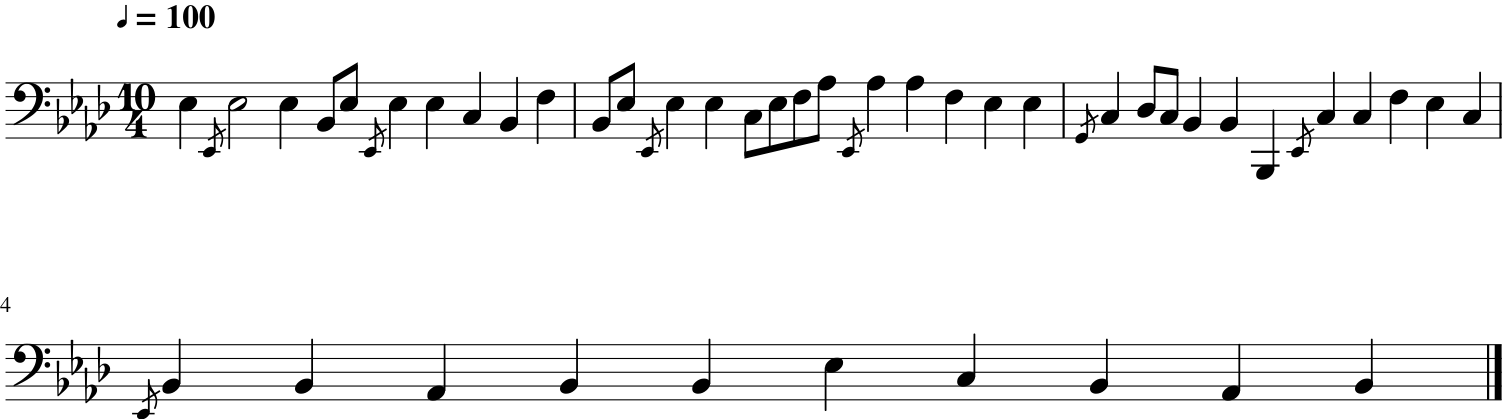

In [30]:
source_decoder(model.enc_converter(src[1:-1])).show()

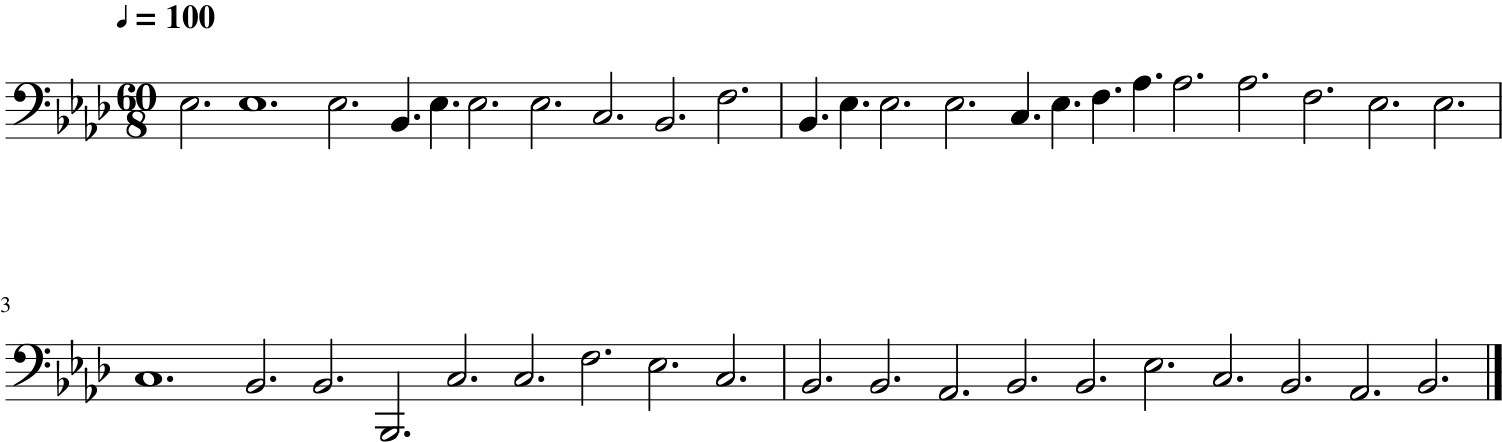

In [32]:
decoder(model.converter(tgt[:-1])).show()

In [81]:
from sejong_music.yeominrak_processing import OrchestraScoreSeq

In [82]:
train_dataset = OrchestraScoreSeq(is_valid= False, 
                              xml_path='music_score/FullScore_edit3.musicxml',
                              use_pitch_modification = config.data.use_pitch_modification, 
                              pitch_modification_ratio=config.data.modification_ratio,
                              min_meas=config.data.min_meas, 
                              max_meas=config.data.max_meas,
                              feature_types=config.model.features,
                              sampling_rate=config.data.sampling_rate
                              )

In [93]:
self = train_dataset

front_part_idx = self.condition_instruments
back_part_idx = self.target_instrument

source_start_token = [front_part_idx[0], 'start', 'start', 'start', 'start', 'start']
source_end_token = [front_part_idx[0], 'end', 'end', 'end', 'end', 'end']
if self.is_valid:
    measure_list = idx
else:    
    measure_list = self.slice_info[idx]

assert isinstance(front_part_idx, list), "front_part_idx should be a list"
original_source_list = [item for f_idx in front_part_idx for idx in measure_list for item in self.measure_features[f_idx][idx]]
original_target_list = [item for idx in measure_list for item in self.measure_features[back_part_idx][idx]]

if 'measure_idx' in self.tokenizer.key_types:
  m_idx_pos = self.tokenizer.key2idx['measure_idx']
  source_first_measure_idx = original_source_list[0][m_idx_pos]
  target_first_measure_idx = original_target_list[0][m_idx_pos]

  original_source_list = [note[:m_idx_pos] + [note[m_idx_pos]-source_first_measure_idx] + note[m_idx_pos+1:] for note in original_source_list]
  original_target_list = [note[:m_idx_pos] + [note[m_idx_pos]-target_first_measure_idx] + note[m_idx_pos+1:] for note in original_target_list]
condition_shifted_target = self.shift_condition(original_target_list)

target_list = condition_shifted_target[: -1]

if self.use_pitch_modification and not self.is_valid:
    target_list = self.modify_pitch(target_list)
shifted_target_list = condition_shifted_target[1:]

source_list = [source_start_token] + original_source_list + [source_end_token]


In [92]:
source_list[2]

[2, 60.0, 0.5, 2.5, 'none', 0]

In [86]:
self.slice_info[idx]

[144, 145, 146, 147]

In [87]:
original_source_list

[[2, 58.0, 2.5, 0.0, 'strong', 145],
 [2, 60.0, 0.5, 2.5, 'none', 145],
 [2, 63.0, 1.5, 3.0, 'weak', 145],
 [2, 63.0, 3.0, 4.5, 'weak', 145],
 [2, 63.0, 3.0, 7.5, 'weak', 145],
 [2, 63.0, 1.5, 10.5, 'weak', 145],
 [2, 65.0, 3.0, 12.0, 'weak', 145],
 [2, 60.0, 2.5, 0.0, 'strong', 146],
 [2, 58.0, 0.5, 2.5, 'none', 146],
 [2, 65.0, 1.5, 3.0, 'weak', 146],
 [2, 63.0, 2.5, 4.5, 'weak', 146],
 [2, 60.0, 0.5, 7.0, 'none', 146],
 [2, 65.0, 1.5, 7.5, 'weak', 146],
 [2, 68.0, 1.0, 9.0, 'middle', 146],
 [2, 65.0, 0.5, 10.0, 'none', 146],
 [2, 63.0, 1.5, 10.5, 'weak', 146],
 [2, 60.0, 3.0, 12.0, 'weak', 146],
 [2, 63.0, 2.5, 0.0, 'strong', 147],
 [2, 60.0, 0.5, 2.5, 'none', 147],
 [2, 65.0, 1.5, 3.0, 'weak', 147],
 [2, 65.0, 3.0, 4.5, 'weak', 147],
 [2, 65.0, 3.0, 7.5, 'weak', 147],
 [2, 68.0, 1.5, 10.5, 'weak', 147],
 [2, 68.0, 2.5, 12.0, 'weak', 147],
 [2, 65.0, 0.5, 14.5, 'none', 147],
 [2, 63.0, 3.0, 0.0, 'strong', 148],
 [2, 60.0, 1.0, 3.0, 'weak', 148],
 [2, 58.0, 0.5, 4.0, 'none', 148],
 [

In [83]:
train_dataset[0]

TypeError: unhashable type: 'list'